# Using Tensorflow DALI plugin: simple example

### Overview

Using our DALI data loading and augmentation pipeline with Tensorflow is pretty simple.

We can summarize the integration in 3 steps :

- Defining a DALI Pipeline
- Give the pipeline to `DALIIterator` op
- Instatiate the op in TensorFlow graph and use it

### Defining the Data Loading Pipeline

First we start by defining some parameters for DALI and Tensorflow.

In this tutorial, we will use a subsample of Imagenet stored in an MXNet's RecordIO. For details on how to use [readers.mxnet](../../../operations/nvidia.dali.fn.readers.mxnet.html), as well as other readers, please see other [examples](../../index.rst).

`DALI_EXTRA_PATH` environment variable should point to the place where data from [DALI extra repository](https://github.com/NVIDIA/DALI_extra) is downloaded. Please make sure that the proper release tag is checked out.

In [1]:
import os.path

test_data_root = os.environ["DALI_EXTRA_PATH"]

# MXNet RecordIO
base = os.path.join(test_data_root, "db", "recordio")

idx_files = [base + "/train.idx"]
rec_files = [base + "/train.rec"]

BATCH_SIZE = 32
ITERATIONS = 32
BURNIN_STEPS = 16

In order to use DALI we need those 3 imports:

In [2]:
from nvidia.dali import pipeline_def, Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types

Then we can define our pipeline by declaring `rn50_pipeline` as as sublass of `dali.pipeline.Pipeline`.
We declare the operators the pipeline will need in the constructor. Then we define the graph in `define_graph`.

This is the usual DALI Pipeline creation.
For more information about DALI Pipeline, please take a look at [Getting Started notebook](../../getting_started.ipynb).

Note again that we are using [readers.mxnet](../../../operations/nvidia.dali.fn.readers.mxnet.html) that reads MXNet's dataset format [RecordIO](http://mxnet.incubator.apache.org/architecture/note_data_loading.html). You can change it to other reader operators to use any of the supported dataset format.

In [3]:
@pipeline_def(batch_size=BATCH_SIZE, num_threads=4)
def rn50_pipeline(device):
    jpegs, labels = fn.readers.mxnet(
        path=rec_files, index_path=idx_files, name="Reader"
    )
    images = fn.decoders.image(
        jpegs, device="mixed" if device == "gpu" else "cpu"
    )
    images = fn.resize(
        images,
        resize_shorter=fn.random.uniform(range=(256.0, 480.0)),
        interp_type=types.INTERP_LINEAR,
    )
    images = fn.crop_mirror_normalize(
        images,
        crop_pos_x=fn.random.uniform(range=(0.0, 1.0)),
        crop_pos_y=fn.random.uniform(range=(0.0, 1.0)),
        dtype=types.FLOAT,
        crop=(224, 224),
        mean=[128.0, 128.0, 128.0],
        std=[1.0, 1.0, 1.0],
    )
    images = fn.cast(images, dtype=types.INT32)

    if device == "gpu":
        labels = labels.gpu()

    return images, labels

Next, we instatiate the pipelines with the right parameters. We will create one pipeline per GPU, by specifying the right `device_id` for each pipeline.

The difference is that instead of calling `pipeline.build` and using it, we will pass the pipeline object to the TensorFlow operator.

In [4]:
pipe = rn50_pipeline(device_id=0, device="gpu")

### Using DALI TensorFlow Plugin

Let's start by importing Tensorflow and the DALI Tensorflow plugin as `dali_tf`.

In [5]:
import tensorflow as tf
import nvidia.dali.plugin.tf as dali_tf
import time

from tensorflow.compat.v1 import GPUOptions
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import Session
from tensorflow.compat.v1 import placeholder

tf.compat.v1.disable_eager_execution()

We can now use `nvidia.dali.plugin.tf.DALIIterator()` method to get the Tensorflow Op that will produce the tensors we will
use in the Tensorflow graph.

For each DALI pipeline, we use `daliop` that returns a Tensorflow tensor tuple that we will store in `image, label`. Each one is using a different `tf.device`.

In [6]:
daliop = dali_tf.DALIIterator()

images = []
labels = []
with tf.device("/gpu:0"):
    image, label = daliop(
        pipeline=pipe,
        shapes=[(BATCH_SIZE, 3, 224, 224), ()],
        dtypes=[tf.int32, tf.float32],
    )

    images.append(image)
    labels.append(label)

### Using the Tensors in a Simple Tensorflow Graph

We will use `images` and `labels` tensors list in our Tensorflow graph definition.
Then run a very simple _one op graph_ session that will output the batch of images and labels.  

In [7]:
gpu_options = GPUOptions(per_process_gpu_memory_fraction=0.8)
config = ConfigProto(gpu_options=gpu_options)

with Session(config=config) as sess:
    all_img_per_sec = []
    total_batch_size = BATCH_SIZE

    for i in range(ITERATIONS):
        start_time = time.time()

        # The actual run with our dali_tf tensors
        res = sess.run([images, labels])

        elapsed_time = time.time() - start_time
        img_per_sec = total_batch_size / elapsed_time
        if i > BURNIN_STEPS:
            all_img_per_sec.append(img_per_sec)
            print("\t%7.1f img/s" % img_per_sec)

    print(
        "Total average %7.1f img/s"
        % (sum(all_img_per_sec) / len(all_img_per_sec))
    )

	 1807.8 img/s
	 1776.1 img/s
	 1926.8 img/s
	 1844.0 img/s
	 1787.0 img/s
	 1932.2 img/s
	 1792.4 img/s
	 1724.5 img/s
	 1436.6 img/s
	 1724.1 img/s
	 1711.2 img/s
	 1662.4 img/s
	 1694.4 img/s
	 1382.5 img/s
	 1423.9 img/s
Total average  1708.4 img/s


Let us check the output images with their augmentations! Tensorflow outputs numpy arrays, so we can visualize them easily with `matplotlib`.

We define a `show_images` helper function that will display a sample of our batch.

The batch layout is NCHW so we use transpose to get HWC images, that `matplotlib` can show.

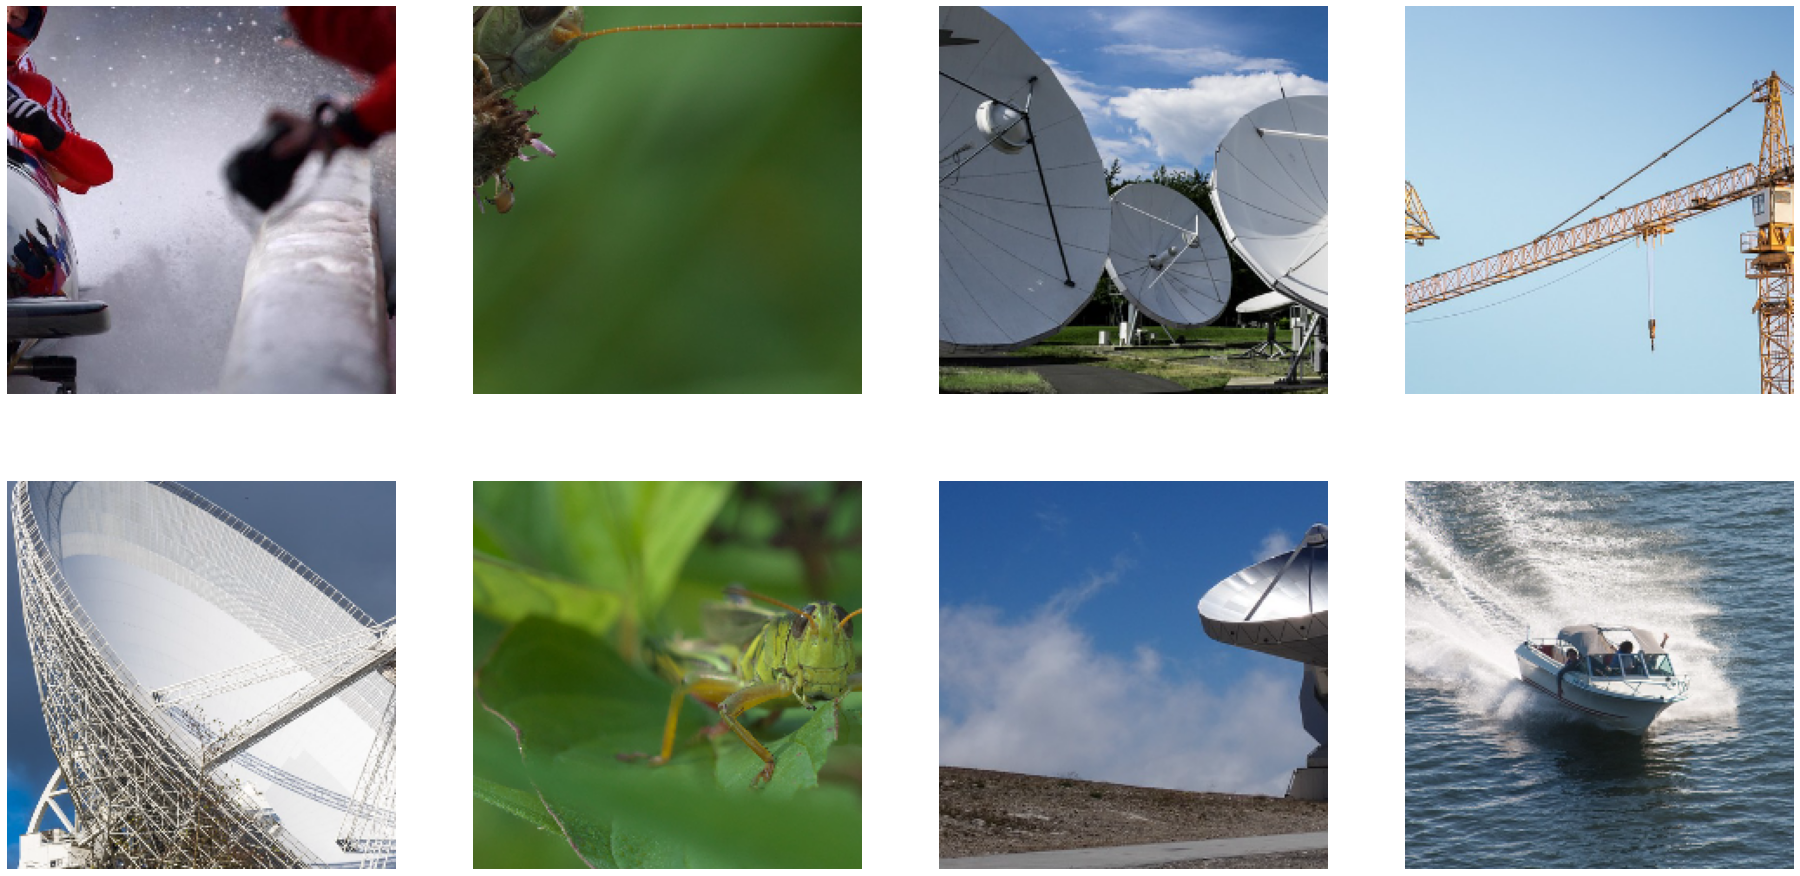

In [8]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

%matplotlib inline


def show_images(image_batch, nb_images):
    columns = 4
    rows = (nb_images + 1) // (columns)
    fig = plt.figure(figsize=(32, (32 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(nb_images):
        plt.subplot(gs[j])
        plt.axis("off")
        img = image_batch[0][j].transpose((1, 2, 0)) + 128
        plt.imshow(img.astype("uint8"))


show_images(res[0], 8)

Let us create the same operator for the CPU:

	  467.6 img/s
	  445.4 img/s
	  498.5 img/s
	  436.1 img/s
	  431.3 img/s
	  478.7 img/s
	  354.2 img/s
	  417.8 img/s
	  459.0 img/s
	  685.4 img/s
	  436.5 img/s
	  465.8 img/s
	  483.0 img/s
	  434.8 img/s
	  460.5 img/s
Total average   463.6 img/s


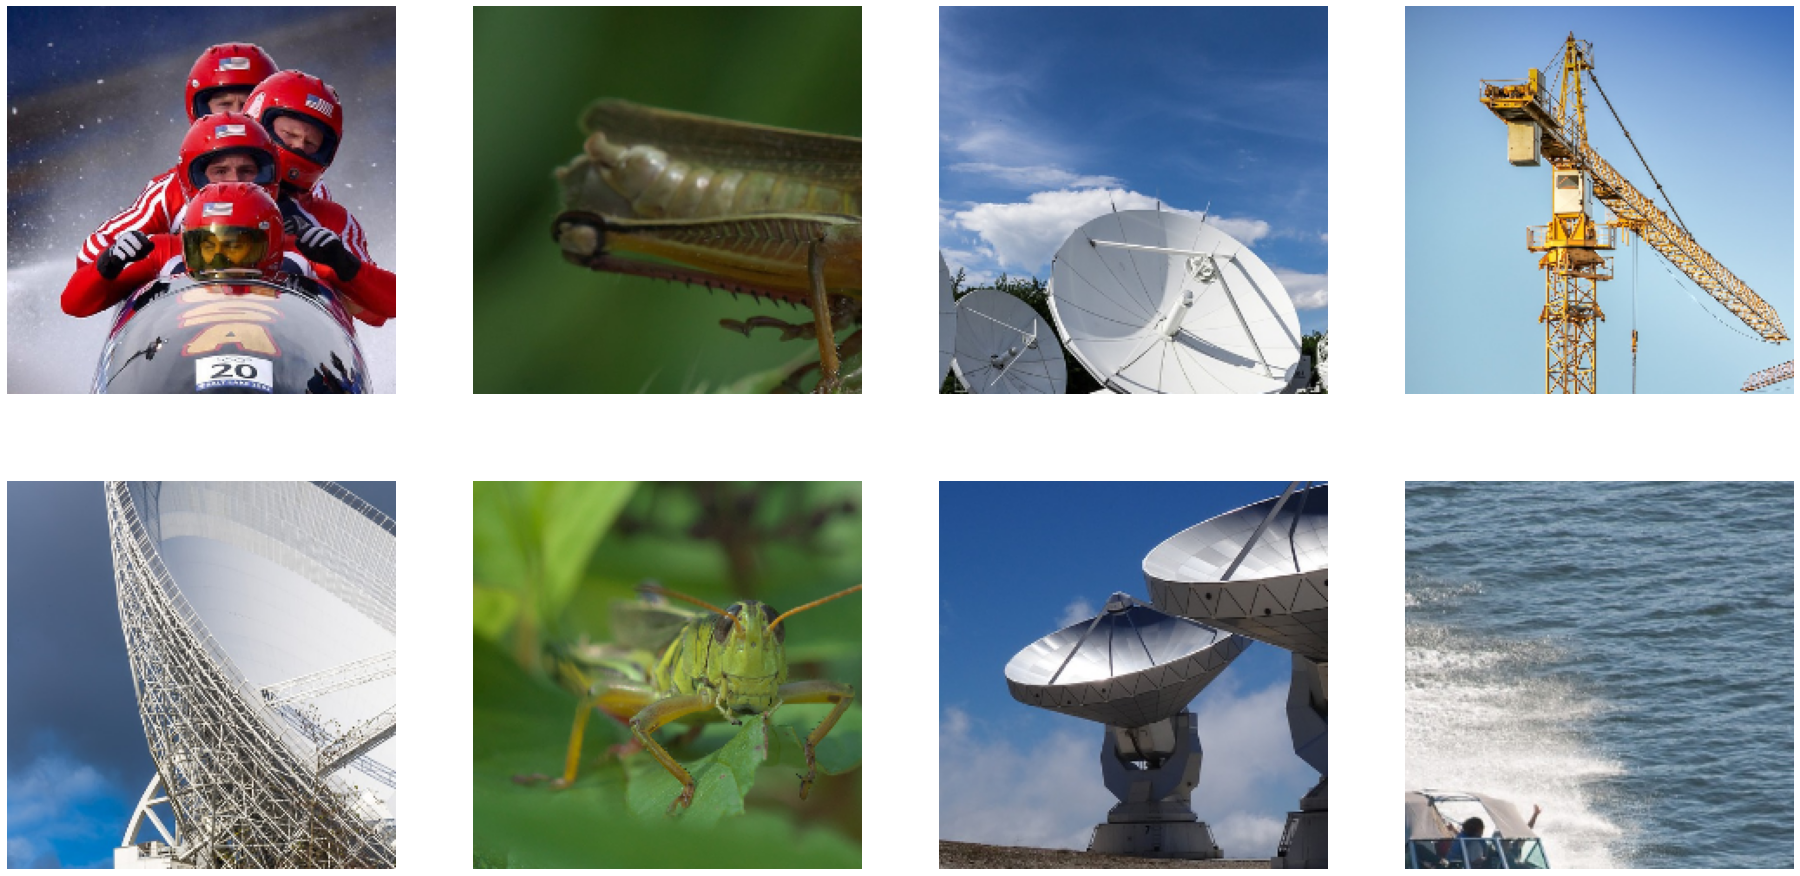

In [9]:
cpu_pipe = rn50_pipeline(device="cpu", device_id=0)

daliop = dali_tf.DALIIterator()

images_cpu = []
labels_cpu = []
with tf.device("/cpu"):
    image_cpu, label_cpu = daliop(
        pipeline=cpu_pipe,
        shapes=[(BATCH_SIZE, 3, 224, 224), ()],
        dtypes=[tf.int32, tf.float32],
    )

    images_cpu.append(image_cpu)
    labels_cpu.append(label_cpu)

with Session() as sess:
    all_img_per_sec = []
    total_batch_size = BATCH_SIZE

    for i in range(ITERATIONS):
        start_time = time.time()

        # The actual run with our dali_tf tensors
        res_cpu = sess.run([images_cpu, labels_cpu])

        elapsed_time = time.time() - start_time
        img_per_sec = total_batch_size / elapsed_time
        if i > BURNIN_STEPS:
            all_img_per_sec.append(img_per_sec)
            print("\t%7.1f img/s" % img_per_sec)

    print(
        "Total average %7.1f img/s"
        % (sum(all_img_per_sec) / len(all_img_per_sec))
    )
show_images(res_cpu[0], 8)